In [1]:
cd C:/Users/nashere2/Documents/Mutation-Accumulation-Experiments

C:\Users\nashere2\Documents\Mutation-Accumulation-Experiments


In [2]:
import RTEpopulation as RTEpop
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
class rtePopulationArray(RTEpop.rtePopulationInterface):
    
    def __init__(self, population_distribution, min_active, min_inactive, min_compensating,
                 fitness_function, population_growth_function, p_full_insert, p_partial_insert,
                 p_deactivate, p_compensate, time=0,alpha=1):

        self.population_distribution = np.atleast_3d(population_distribution)
        num_actives = self.population_distribution.shape[0]
        num_inactives = self.population_distribution.shape[1]
        num_compensatings = self.population_distribution.shape[2]
        self.actives = np.arange(min_active, min_active + num_actives).reshape(num_actives, 1, 1)
        self.inactives = np.arange(min_inactive, min_inactive + num_inactives).reshape(1, num_inactives, 1)
        self.compensatings = np.arange(min_compensating, min_compensating + num_compensatings).reshape(1, 1, num_compensatings)

        self.fitness_function = fitness_function
        self.population_growth_function = population_growth_function
        
        if p_full_insert < 0:
            raise ValueError('p_full_insert must be >=0')
        self.p_full_insert = p_full_insert

        if p_partial_insert < 0:
            raise ValueError('p_partial_insert must be >=0')
        self.p_partial_insert = p_partial_insert

        if p_deactivate < 0:
            raise ValueError('p_deactivate must be >=0')
        self.p_deactivate = p_deactivate

        if p_compensate < 0:
            raise ValueError('p_deactivate must be >=0')
        self.p_compensate = p_compensate
        
        self.time = time
        self.alpha = alpha
    
    def __repr__(self):
        actives_str = repr(self.actives)
        inactives_str = repr(self.inactives)
        compensating_str = repr(self.compensatings)
        full_distribution_str = repr(self.population_distribution)
        return_str = "active_RTE's:\n" + actives_str + "\n" + \
            "inactive_RTE's:\n" + inactives_str + "\n" + \
            "compensating mutations:\n" + compensating_str + "\n" + \
            "population distribution:\n" +  full_distribution_str + "\n"
        return return_str

    def full_distribution(self):
        return self.actives, self.inactives, self.compensatings, self.population_distribution

    def active_rte_dist(self):
        active_distribution = np.sum(np.sum(self.population_distribution, 1), 1)
        return self.actives.flatten(), active_distribution

    def mean_active_rtes(self):
        active, active_distribution = self.active_rte_dist()
        return np.sum(active.astype('float64')*active_distribution)/np.sum(active_distribution)

    def inactive_rte_dist(self):
        inactive_distribution = np.sum(np.sum(self.population_distribution, 0), 1)
        return self.inactives.flatten(), inactive_distribution

    def mean_inactive_rtes(self):
        inactive, inactive_distribution = self.inactive_rte_dist()
        return np.sum(inactive.astype('float64')*inactive_distribution) / \
            np.sum(inactive_distribution)

    def compensating_mutations_dist(self):
        compensating_distribution = np.sum(np.sum(self.population_distribution, 0), 0)
        return self.compensatings.flatten(), compensating_distribution

    def mean_compensating_mutations(self):
        compensating, compensating_distribution = \
            self.compensating_mutations_dist()
        return np.sum(compensating.astype('float64')*compensating_distribution) / \
            np.sum(compensating_distribution)

    def fitness_dist(self):
        fitnesses = self.fitness_function(self.actives, self.inactives, self.compensatings).flatten()
        fitness_dist = self.population_distribution.flatten()
        sort_order = fitnesses.argsort()
        fitnesses = fitnesses[sort_order]
        fitness_dist = fitness_dist[sort_order]
        unique_fitnesses = []
        unique_fitness_dist = []
        current_fitness_class = fitnesses[0]
        current_total = 0
        for i, fit in enumerate(fitnesses):
            if fit != current_fitness_class:
                unique_fitnesses.append(current_fitness_class)
                unique_fitness_dist.append(current_total)
                current_total = 0
                current_fitness_class = fit
            current_total = current_total + fitness_dist[i]
        unique_fitnesses.append(current_fitness_class)
        unique_fitness_dist.append(current_total)
        return np.array(unique_fitnesses), np.array(unique_fitness_dist)

    def mean_fitness(self):
        fitnesses, fitness_distribution = self.fitness_dist()
        return np.sum(fitnesses*fitness_distribution)/np.sum(fitness_distribution)

    def growth_rate_dist(self):
        fitnesses, fitness_dist = self.fitness_dist()
        r = self.mean_growth_rate()
        return fitnesses - self.mean_fitness() + r, fitness_dist

    def mean_growth_rate(self):
        r = self.population_growth_function(np.sum(self.population_distribution), self.time)
        return r

    def update(self, dt):
        if np.sum(self.population_distribution) == 0:
            raise StopIteration('This population has no individuals in it')
        self._mutations(dt)
        mean_f = self.mean_fitness()
        r = self.mean_growth_rate()
        births = self._births(dt, mean_f, r)
        deaths = self._deaths(dt, mean_f, r)
        self.population_distribution = self.population_distribution + births - deaths
        self.time = self.time + dt

    def _mutations(self, dt):
        dt_left = dt
        while dt_left > 0:
            step_size = min(dt_left, self.step_size())
            self._dmutate(step_size)
            dt_left = dt_left - step_size

    def step_size(self):
        max_active = self.actives[-1,0,0]
        max_inactive = self.inactives[0,-1,0]
        min_compensating = self.compensatings[0,0,0]
        step_size = .05/( (self.p_full_insert+self.p_partial_insert+self.p_deactivate)*max_active +
                  self.p_compensate*(max_active+max_inactive-min_compensating) )
        return step_size

    def _dmutate(self, dt):
        '''Do not call this method directly. It is for small timesteps.
        
        The simulation results will break in a possibly unnoticeable manner if dt is too big.'''
        p_active_up = self.p_full_insert*dt*self.actives
        active_increase = np.random.binomial(self.population_distribution,p_active_up)
        self.population_distribution = self.population_distribution - active_increase
        active_increase = np.pad(active_increase, ((2,0),(0,1),(0,1)), 'constant')

        p_inactive_up = self.p_partial_insert*dt*self.actives
        inactive_increase = np.random.binomial(self.population_distribution, p_inactive_up/(1-p_active_up))
        self.population_distribution = self.population_distribution - inactive_increase
        inactive_increase = np.pad(inactive_increase, ((1,1),(1,0),(0,1)), 'constant')

        p_deactivate_up = self.p_deactivate*dt*self.actives
        deactivate_increase = np.random.binomial(self.population_distribution, p_deactivate_up/(1-p_active_up-p_inactive_up))
        self.population_distribution = self.population_distribution - deactivate_increase
        deactivate_increase = np.pad(deactivate_increase, ((0,2),(1,0),(0,1)), 'constant')

        p_compensate_up = np.maximum(self.p_compensate*dt*(self.actives+self.inactives-self.compensatings),0)
        compensate_increase = np.random.binomial(self.population_distribution,
                                                 p_compensate_up/(1-p_active_up-p_inactive_up-p_deactivate_up))
        self.population_distribution = self.population_distribution - compensate_increase
        compensate_increase = np.pad(compensate_increase, ((1,1),(0,1),(1,0)), 'constant')

        self.actives = np.pad(self.actives, ((1,1),(0,0),(0,0)), 'linear_ramp',
                              end_values=((self.actives[0,0,0]-1,self.actives[-1,0,0]+1),(0,0),(0,0)))
        self.inactives = np.pad(self.inactives, ((0,0),(0,1),(0,0)), 'linear_ramp',
                              end_values=((0,0),(0,self.inactives[0,-1,0]+1),(0,0)))
        self.compensatings = np.pad(self.compensatings, ((0,0),(0,0),(0,1)), 'linear_ramp',
                              end_values=((0,0),(0,0),(0,self.compensatings[0,0,-1]+1)))
        self.population_distribution = np.pad(self.population_distribution, ((1,1),(0,1),(0,1)), 'constant')
        self.population_distribution = self.population_distribution + active_increase + inactive_increase + \
            deactivate_increase + compensate_increase
        self._trim_updates()

    def _trim_updates(self):
        while np.sum(self.population_distribution[0,:,:]) == 0:
            self.population_distribution = np.delete(self.population_distribution, 0, 0)
            self.actives = np.delete(self.actives, 0, 0)
        while np.sum(self.population_distribution[-1,:,:]) == 0:
            self.population_distribution = np.delete(self.population_distribution, -1, 0)
            self.actives = np.delete(self.actives, -1, 0)
        while np.sum(self.population_distribution[:,0,:]) == 0:
            self.population_distribution = np.delete(self.population_distribution, 0, 1)
            self.inactives = np.delete(self.inactives , 0, 1)
        while np.sum(self.population_distribution[:,-1,:]) == 0:
            self.population_distribution = np.delete(self.population_distribution, -1, 1)
            self.inactives = np.delete(self.inactives , -1, 1)
        while np.sum(self.population_distribution[:,:,0]) == 0:
            self.population_distribution = np.delete(self.population_distribution, 0, 2)
            self.compensatings = np.delete(self.compensatings , 0, 2)
        while np.sum(self.population_distribution[:,:,-1]) == 0:
            self.population_distribution = np.delete(self.population_distribution, -1, 2)
            self.compensatings = np.delete(self.compensatings , -1, 2)
        

    def _births(self, dt, mean_f, r):
        fitnesses = self.fitness_function(self.actives, self.inactives, self.compensatings)
        test = fitnesses - mean_f + r
        high_f = (test>0)*self.population_distribution
        low_f = (test<=0)*self.population_distribution
        high_births = np.random.poisson(high_f*(test+self.alpha)*(test>0)*dt)
        low_births = np.random.poisson(low_f*self.alpha*dt)
        return high_births + low_births

    def _deaths(self, dt, mean_f, r):
        fitnesses = self.fitness_function(self.actives, self.inactives, self.compensatings)
        test = fitnesses - mean_f + r
        high_f = (test>0)*self.population_distribution
        low_f = (test<=0)*self.population_distribution
        high_deaths = np.random.binomial(high_f, self.alpha*dt)
        low_deaths = np.random.binomial(low_f, -(test-self.alpha)*(test<=0)*dt)
        return high_deaths + low_deaths

In [4]:
def test_fitness_function(active, inactive, compensating):
    return -.001 * (active + inactive - compensating)

def test_growth_rate_function(N, t):
    return (1 - N/(10**9))

In [5]:
testpop = rtePopulationArray(10**3, 20, 0, 0, test_fitness_function, test_growth_rate_function, .001, .01, .0001, 0)

In [6]:
mean_active=[testpop.mean_active_rtes()]
mean_inactive=[testpop.mean_inactive_rtes()]
mean_compensating=[testpop.mean_compensating_mutations()]
mean_fitness=[testpop.mean_fitness()]
mean_growth_rate=[testpop.mean_growth_rate()]
pop_size=[np.sum(testpop.population_distribution)]
for gen in range(20):
    for i in range(10):
        testpop.update(.1)
    mean_active.append(testpop.mean_active_rtes())
    mean_inactive.append(testpop.mean_inactive_rtes())
    mean_compensating.append(testpop.mean_compensating_mutations())
    mean_fitness.append(testpop.mean_fitness())
    mean_growth_rate.append(testpop.mean_growth_rate())
    pop_size.append(np.sum(testpop.population_distribution))

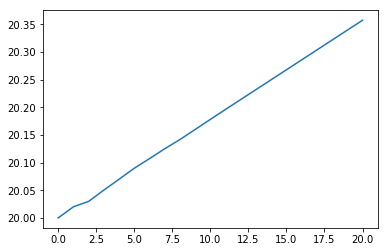

In [7]:
plt.plot(mean_active)

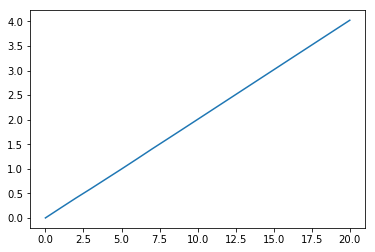

In [8]:
plt.plot(mean_inactive)

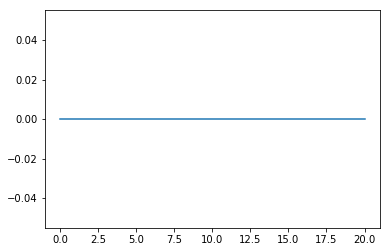

In [9]:
plt.plot(mean_compensating)

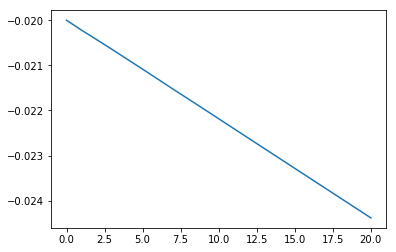

In [10]:
plt.plot(mean_fitness)

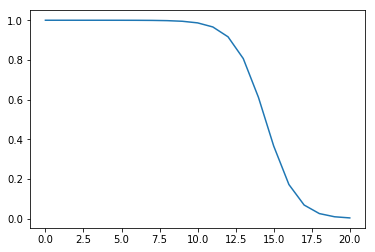

In [11]:
plt.plot(mean_growth_rate)

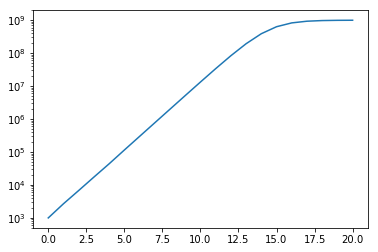

In [12]:
plt.semilogy(pop_size)